In [1]:
import re
import json

def judge_node_same(obs_nodes_info_a, obs_nodes_info_b, threshold=3):
    """
    判断两个状态之间的节点差异是否超过阈值
    obs_nodes_info_a 和 b 都是一个字典，字典的key是节点id，value 是一个字典，例如：
    '11765': {'backend_id': 19269,
    'union_bound': [0.0, 0.0, 10.0, 10.0],
    'text': "[11765] RootWebArea 'Postmill' focused: True"}

    对于 obs_nodes_info_a 的一个元素，如果 obs_nodes_info_b 中存在一个元素，其 union_bound 一致，并且 text 去掉 [xxx] 后一致，则认为两个元素是相同的
    如果不同的元素小于等于 threshold，则认为两个状态是相同的
    这里所谓的 key 和 backend_id 都不重要，不作为参考依据

    返回值：
    - 如果两个状态差异小于等于 threshold，相同，返回 True
    - 如果两个状态差异超过阈值，返回 False
    """

    diff_count = 0

    b_nodes_set = set()
    for node_id, node_info in obs_nodes_info_b.items():
        union_bound = node_info['union_bound']
        cleaned_text = re.sub(r'\[.*?\]', '', node_info['text'])
        b_nodes_set.add(f"{union_bound}_{cleaned_text}")

    for node_id, node_info in obs_nodes_info_a.items():
        union_bound = node_info['union_bound']
        cleaned_text = re.sub(r'\[.*?\]', '', node_info['text'])
        if f"{union_bound}_{cleaned_text}" not in b_nodes_set:
            diff_count += 1

    if diff_count <= threshold:
        # print(f"diff_count: {diff_count} <= threshold: {threshold}, same nodes")
        return True
    # print(diff_count)
    return False

In [2]:
def a11y_to_components(a11y):
    """
    将 a11y 转换为组件列表
    """
    # 对于每一行
    # 如果包含 [xxx]，则去掉 [xxx]，将后面的内容视作一个组件

    components = []
    for line in a11y.split("\n"):
        # 去掉前后空格
        line = line.strip()
        if line == "":
            continue
        match = re.match(r'\[(\d+)\]', line)
        if match:
            # component_id = match.group(1)
            component_content = line[match.end():].strip()
            components.append(component_content)
        else:
            components.append(line)
    return components


In [3]:
# def judge_node_same_from_a11y(a11y_a, a11y_b, threshold=3):
#     """
#     判断两个状态之间的节点差异是否超过阈值
#     a11y_a 和 b 都是一个字符串，字符串的格式为例如：
#     [5207] heading 'relationship_advice — relationship_advice'
#         [5209] link 'relationship_advice — relationship_advice'
#     [5215] button 'Subscribe No subscribers'
#         [5571] generic 'No subscribers'
#     [5216] StaticText '5,721 submissions'

#     首先去掉前面的 [xxx]，将后面的内容视作一个组件

#     对于 a11y_a 的一个组件，如果 a11y_b 中存在一个组件，其组件内容一致，则认为两个组件是相同的
#     如果不同的组件小于 threshold，则认为两个状态是相同的

#     返回值：
#     - 如果两个状态差异小于等于 threshold，相同，返回 True
#     - 如果两个状态差异超过阈值，返回 False
#     """

#     diff_count = 0

#     a_components = a11y_to_components(a11y_a)
#     b_components = a11y_to_components(a11y_b)

#     for a_component in a_components:
#         if a_component not in b_components:
#             diff_count += 1
#     # print(diff_count)
#     return diff_count <= threshold

In [4]:
# judge_node_same_from_a11y(trajs[0]["a11y_before"], trajs[2]["a11y_after"])

In [5]:
from rank_bm25 import BM25Okapi
def bm25_retrieval(query, corpus, top_n=3):
    tokenized_corpus = [doc.split(" ") for doc in corpus]
    bm25 = BM25Okapi(tokenized_corpus)
    tokenized_query = query.split(" ")
    top_n_docs = bm25.get_top_n(tokenized_query, corpus, n=top_n)
    top_n_docs_index = [corpus.index(doc) for doc in top_n_docs]
    return top_n_docs_index

In [6]:
# judge_node_difference(data[0]["state_before"]['text']['obs_nodes_info'], data[2]["state_after"]['text']['obs_nodes_info'])
# bm25_retrieval('a', ['bcc', 'a v'])

In [7]:
import os
total_file_names = []

dir_paths = [
    "/home/zjusst/qms/webarena/result_stage_1_explore_v2/add_local_intention_trajs",
    "/home/zjusst/qms/webarena/result_stage_2_intended_explore/add_local_intention_trajs",
    "/home/zjusst/qms/webarena/result_stage_2_intended_explore_2/add_local_intention_trajs",
]

for dir_path in dir_paths:
    file_names = os.listdir(dir_path)
    file_names = [f"{dir_path}/{file_name}" for file_name in file_names if file_name.endswith(".json")]
    # file_names.sort() 自定义排序，按照 _ 分割，取后面的数字排序
    # file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    print("len(file_names)", len(file_names))
    total_file_names.extend(file_names)

len(total_file_names)


len(file_names) 55
len(file_names) 30
len(file_names) 29


114

In [8]:
# with open("/home/zjusst/qms/webarena/result_stage_1_explore_v2/add_local_intention_trajs/812_1.json", "r") as f:
#     trajs = json.load(f)

# trajs[5]
# trajs[1]["state_after"]
# judge_node_same(trajs[i]["state_before"]['text']['obs_nodes_info'], trajs[i]["state_after"]['text']['obs_nodes_info'], 3)

In [13]:
from tqdm import tqdm

unique_page_ids = []  # (file_name, traj_idx, 0|1代表前还是后, real_url) 
unique_page_a11ys = []
unique_page_nodes = []
records = []  # (page_id, action, intention, page_id)

unique_page_id_count_list = []
same_nodes_count = 0
same_nodes_count_list = []

for file_name in tqdm(total_file_names):
    same_nodes_count_list.append(same_nodes_count)
    unique_page_id_count_list.append(len(unique_page_ids))
    # print(f"same_nodes_count: {same_nodes_count}")
    # print(f"unique_page_ids: {len(unique_page_ids)}")
    try:
        with open(file_name, "r") as f:
            trajs = json.load(f)
    except Exception as e:
        print(f"Error loading {file_name}: {e}, skip")
        continue

    for traj_idx, traj in enumerate(trajs):
        if len(unique_page_ids) == 0:
            unique_page_ids.append((file_name, traj_idx, 0, traj['url_real_before']))
            unique_page_a11ys.append(traj["a11y_before"])
            unique_page_nodes.append(traj["state_before"]['text']['obs_nodes_info'])

        prev_page_id = -1
        # 从 unique_page_a11ys 检索出最接近的三个
        top_n_docs_index = bm25_retrieval(traj["a11y_before"], unique_page_a11ys, 3)
        for doc_idx in top_n_docs_index:
            if judge_node_same(traj["state_before"]['text']['obs_nodes_info'], unique_page_nodes[doc_idx], 4):
                prev_page_id = unique_page_ids[doc_idx]
                same_nodes_count += 1
                break
            # if judge_node_same_from_a11y(traj["a11y_before"], unique_page_a11ys[doc_idx], 3):
            #     prev_page_id = unique_page_ids[doc_idx]
            #     break
        if prev_page_id == -1:
            unique_page_ids.append((file_name, traj_idx, 0, traj['url_real_before']))
            unique_page_a11ys.append(traj["a11y_before"])
            unique_page_nodes.append(traj["state_before"]['text']['obs_nodes_info'])
            prev_page_id = unique_page_ids[-1]

        action_str = traj["action_str"]
        intention = traj["intention"]

        after_page_id = -1
        top_n_docs_index = bm25_retrieval(traj["a11y_after"], unique_page_a11ys, 3)
        for doc_idx in top_n_docs_index:
            if judge_node_same(traj["state_after"]['text']['obs_nodes_info'], unique_page_nodes[doc_idx], 4):
                after_page_id = unique_page_ids[doc_idx]
                same_nodes_count += 1
                break
            # if judge_node_same_from_a11y(traj["a11y_after"], unique_page_a11ys[doc_idx], 3):
            #     after_page_id = unique_page_ids[doc_idx]
            #     break
        if after_page_id == -1:
            unique_page_ids.append((file_name, traj_idx, 1, traj['url_real_after']))
            unique_page_a11ys.append(traj["a11y_after"])
            unique_page_nodes.append(traj["state_after"]['text']['obs_nodes_info'])
            after_page_id = unique_page_ids[-1]
            
        records.append((prev_page_id, action_str, intention, after_page_id))

print(len(records))


 85%|████████▌ | 97/114 [02:20<00:46,  2.76s/it]

Error loading /home/zjusst/qms/webarena/result_stage_2_intended_explore_2/add_local_intention_trajs/825.json: Expecting ',' delimiter: line 2800 column 205 (char 111182), skip


100%|██████████| 114/114 [03:09<00:00,  1.66s/it]

1998


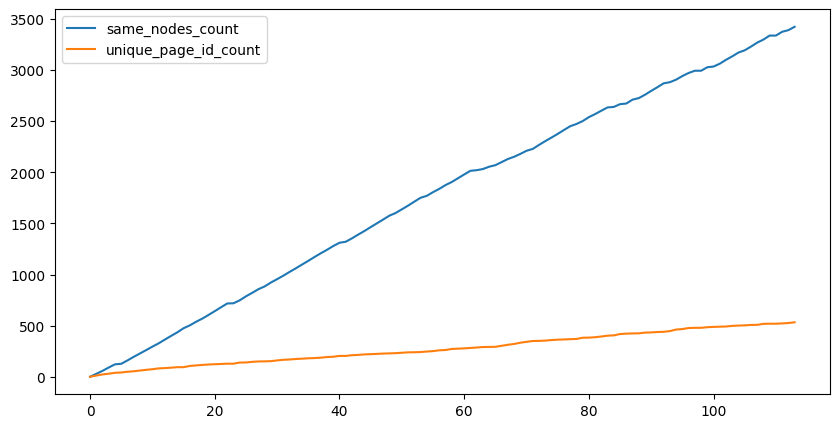

In [14]:
# 绘制 same_nodes_count_list 和 unique_page_id_count_list 的折线图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(same_nodes_count_list, label='same_nodes_count')
plt.plot(unique_page_id_count_list, label='unique_page_id_count')
plt.legend()

In [15]:
len(unique_page_ids)

534

In [16]:
import csv

with open("/home/zjusst/qms/webarena/result_stage_3_generation/flitered_triplets_threshold_5.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["prev_page_id", "action_str", "intention", "after_page_id"])
    writer.writerows(records)

In [11]:
import csv

with open("/home/zjusst/qms/webarena/result_stage_3_generation/flitered_triplets.csv", "r") as f:
    reader = csv.reader(f)
    # 跳过第一行
    next(reader)
    records = [row for row in reader]
print(len(records))
records[0]

1998


["('/home/zjusst/qms/webarena/result_stage_1_explore_v2/add_local_intention_trajs/812_36.json', 0, 0, 'http://reddit.com/')",
 "click [20] where [20] is button 'Sort by: Hot' hasPopup: menu expanded: False",
 'The user wants to sort posts by a different criterion to better organize or view the content on the homepage.',
 "('/home/zjusst/qms/webarena/result_stage_1_explore_v2/add_local_intention_trajs/812_36.json', 0, 1, 'http://reddit.com/')"]

In [3]:
action_parsed_triplets = []
for triplet in records:
    temp_triplet = (
        f"{triplet[0][0]}_{triplet[0][1]}_{triplet[0][2]}_{triplet[0][3]}",
        triplet[1],
        f"{triplet[3][0]}_{triplet[3][1]}_{triplet[3][2]}_{triplet[3][3]}"
    )
    action_parsed_triplets.append(temp_triplet)

intention_parsed_triplets = []
for triplet in records:
    temp_triplet = (
        f"{triplet[0][0]}_{triplet[0][1]}_{triplet[0][2]}_{triplet[0][3]}",
        triplet[2],
        f"{triplet[3][0]}_{triplet[3][1]}_{triplet[3][2]}_{triplet[3][3]}"
    )
    intention_parsed_triplets.append(temp_triplet)

len(action_parsed_triplets), len(intention_parsed_triplets)

(1998, 1998)

In [6]:
import networkx as nx
from pyvis.network import Network

# --------------------------------------------------------------------------
# 1. 你的三元组数据 (用示例数据代替)
# 在实际使用中，你会从文件中加载这些数据
# 格式: (前页面标识, 动作描述, 后页面标识)
# 页面标识可以是页面的URL、截图文件的哈希值或你定义的任何唯一ID
# triplets = [
#     ('HomePage', 'click("Login Button")', 'LoginPage'),
#     ('HomePage', 'click("Products Link")', 'ProductsPage'),
#     ('ProductsPage', 'click("Item 1")', 'Item1_DetailsPage'),
#     ('ProductsPage', 'click("Item 2")', 'Item2_DetailsPage'),
#     ('Item1_DetailsPage', 'click("Add to Cart")', 'ShoppingCartPage'),
#     ('Item2_DetailsPage', 'click("Add to Cart")', 'ShoppingCartPage'),
#     ('LoginPage', 'type("username & password")', 'HomePage'), # 登录后回到主页
#     ('ShoppingCartPage', 'go_back()', 'ProductsPage') # 从购物车返回
# ]
# --------------------------------------------------------------------------


# 2. 使用 NetworkX 创建一个有向图 (因为 A->B 和 B->A 是不同的)
G = nx.DiGraph()

# 3. 遍历三元组数据，填充图的节点和边
for source, action, target in action_parsed_triplets:
    # 添加节点 (如果节点已存在，NetworkX会自动忽略)
    # 我们可以为节点添加属性，例如'title'，当鼠标悬停时会显示
    G.add_node(source, title=f"Page ID: {source}")
    G.add_node(target, title=f"Page ID: {target}")

    # 添加边，并把动作描述作为边的标签
    G.add_edge(source, target, label=action)


# --------------------------------------------------------------------------
# 4. 使用 Pyvis 进行交互式可视化
# 创建一个Pyvis网络图对象
# notebook=True 如果你在Jupyter Notebook中使用
# directed=True 会让边带上箭头，非常重要
net = Network(height='2000px', width='100%', notebook=True, directed=True)

# 从 NetworkX 对象加载图数据
net.from_nx(G)

# 为可视化添加一些物理引擎的选项，让布局更好看
# net.toggle_physics(True)

# 手动设定物理引擎参数
net.set_options("""
{
  "physics": {
    "enabled": true,
    "solver": "forceAtlas2Based",
    "forceAtlas2Based": {
      "springLength": 600
    }
  }
}
""")

# 添加交互UI的选项，例如筛选节点
#net.show_buttons(filter_=['physics'])

# 5. 生成HTML文件
# 这个文件将保存在你的脚本所在的目录下
# 你可以直接在浏览器中打开它
net.show('interactive_graph_threshold_5.html')

print("成功生成 'interactive_graph_threshold_5.html' 文件！请在浏览器中打开查看。")

interactive_graph_threshold_5.html
成功生成 'interactive_graph_threshold_5.html' 文件！请在浏览器中打开查看。


In [4]:
import networkx as nx
from pyvis.network import Network

# 2. 使用 NetworkX 创建一个有向图 (因为 A->B 和 B->A 是不同的)
G = nx.DiGraph()

# 3. 遍历三元组数据，填充图的节点和边
for source, action, target in intention_parsed_triplets:
    # 添加节点 (如果节点已存在，NetworkX会自动忽略)
    # 我们可以为节点添加属性，例如'title'，当鼠标悬停时会显示
    G.add_node(source, title=f"Page ID: {source}")
    G.add_node(target, title=f"Page ID: {target}")

    # 添加边，并把动作描述作为边的标签
    G.add_edge(source, target, label=action)


# --------------------------------------------------------------------------
# 4. 使用 Pyvis 进行交互式可视化
# 创建一个Pyvis网络图对象
# notebook=True 如果你在Jupyter Notebook中使用
# directed=True 会让边带上箭头，非常重要
net = Network(height='2000px', width='100%', notebook=True, directed=True)

# 从 NetworkX 对象加载图数据
net.from_nx(G)

# 为可视化添加一些物理引擎的选项，让布局更好看
# net.toggle_physics(True)

# 手动设定物理引擎参数
net.set_options("""
{
  "physics": {
    "enabled": true,
    "solver": "forceAtlas2Based",
    "forceAtlas2Based": {
      "springLength": 600
    }
  }
}
""")

# 添加交互UI的选项，例如筛选节点
#net.show_buttons(filter_=['physics'])

# 5. 生成HTML文件
# 这个文件将保存在你的脚本所在的目录下
# 你可以直接在浏览器中打开它
net.show('interactive_graph_threshold_5_intention.html')

print("成功生成 'interactive_graph_threshold_5_intention.html' 文件！请在浏览器中打开查看。")

interactive_graph_threshold_5_intention.html
成功生成 'interactive_graph_threshold_5_intention.html' 文件！请在浏览器中打开查看。


In [12]:
from collections import defaultdict, Counter

# 统计出度和入度
# records 格式: [原节点, 动作, 意图, 新节点]

# 1. 统计所有出边（包括自环和平行边）
out_edges_all = defaultdict(list)  # {节点: [所有出边目标节点列表]}
in_edges_all = defaultdict(list)   # {节点: [所有入边源节点列表]}

# 2. 统计出边（不包括自环，但包括平行边）
out_edges_no_self = defaultdict(list)
in_edges_no_self = defaultdict(list)

# 3. 统计出边（不包括自环和平行边）
out_edges_unique = defaultdict(set)  # 使用 set 自动去重
in_edges_unique = defaultdict(set)

# 遍历所有 records
for record in records:
    source = record[0]  # 原节点
    target = record[3]  # 新节点
    
    # 1. 所有出边（包括自环和平行边）
    out_edges_all[source].append(target)
    in_edges_all[target].append(source)
    
    # 2. 不包括自环，但包括平行边
    if source != target:
        out_edges_no_self[source].append(target)
        in_edges_no_self[target].append(source)
    
    # 3. 不包括自环和平行边（使用 set 去重）
    if source != target:
        out_edges_unique[source].add(target)
        in_edges_unique[target].add(source)

# 获取所有节点
all_nodes = set()
for record in records:
    all_nodes.add(record[0])  # 原节点
    all_nodes.add(record[3])  # 新节点

# 计算每个节点的度数
out_degree_all = {node: len(out_edges_all[node]) for node in all_nodes}
in_degree_all = {node: len(in_edges_all[node]) for node in all_nodes}

out_degree_no_self = {node: len(out_edges_no_self[node]) for node in all_nodes}
in_degree_no_self = {node: len(in_edges_no_self[node]) for node in all_nodes}

out_degree_unique = {node: len(out_edges_unique[node]) for node in all_nodes}
in_degree_unique = {node: len(in_edges_unique[node]) for node in all_nodes}

# 计算平均值
num_nodes = len(all_nodes)

avg_out_degree_all = sum(out_degree_all.values()) / num_nodes if num_nodes > 0 else 0
avg_in_degree_all = sum(in_degree_all.values()) / num_nodes if num_nodes > 0 else 0

avg_out_degree_no_self = sum(out_degree_no_self.values()) / num_nodes if num_nodes > 0 else 0
avg_in_degree_no_self = sum(in_degree_no_self.values()) / num_nodes if num_nodes > 0 else 0

avg_out_degree_unique = sum(out_degree_unique.values()) / num_nodes if num_nodes > 0 else 0
avg_in_degree_unique = sum(in_degree_unique.values()) / num_nodes if num_nodes > 0 else 0

# 计算最大值
max_out_degree_all = max(out_degree_all.values()) if out_degree_all else 0
max_in_degree_all = max(in_degree_all.values()) if in_degree_all else 0

max_out_degree_no_self = max(out_degree_no_self.values()) if out_degree_no_self else 0
max_in_degree_no_self = max(in_degree_no_self.values()) if in_degree_no_self else 0

max_out_degree_unique = max(out_degree_unique.values()) if out_degree_unique else 0
max_in_degree_unique = max(in_degree_unique.values()) if in_degree_unique else 0

# 打印统计结果
print("=" * 80)
print("基于 records 的图统计信息")
print("=" * 80)
print(f"总节点数: {num_nodes}")
print(f"总边数（包括自环和平行边）: {len(records)}")
print()

print("出度统计（Out Degree）:")
print("-" * 80)
print(f"  平均出度（包括自环和平行边）: {avg_out_degree_all:.4f}")
print(f"  平均出度（不包括自环，包括平行边）: {avg_out_degree_no_self:.4f}")
print(f"  平均出度（不包括自环和平行边）: {avg_out_degree_unique:.4f}")
print()
print(f"  最大出度（包括自环和平行边）: {max_out_degree_all}")
print(f"  最大出度（不包括自环，包括平行边）: {max_out_degree_no_self}")
print(f"  最大出度（不包括自环和平行边）: {max_out_degree_unique}")
print()

print("入度统计（In Degree）:")
print("-" * 80)
print(f"  平均入度（包括自环和平行边）: {avg_in_degree_all:.4f}")
print(f"  平均入度（不包括自环，包括平行边）: {avg_in_degree_no_self:.4f}")
print(f"  平均入度（不包括自环和平行边）: {avg_in_degree_unique:.4f}")
print()
print(f"  最大入度（包括自环和平行边）: {max_in_degree_all}")
print(f"  最大入度（不包括自环，包括平行边）: {max_in_degree_no_self}")
print(f"  最大入度（不包括自环和平行边）: {max_in_degree_unique}")
print()

# 额外统计：自环和平行边信息
self_loops = sum(1 for record in records if record[0] == record[3])
print("额外统计:")
print("-" * 80)
print(f"  自环数量: {self_loops}")
print(f"  自环比例: {self_loops / len(records) * 100:.2f}%")

# 统计平行边（相同起点终点的边）
edge_counter = Counter((record[0], record[3]) for record in records)
parallel_edges = sum(count - 1 for count in edge_counter.values() if count > 1)
print(f"  平行边数量: {parallel_edges}")
print(f"  平行边比例: {parallel_edges / len(records) * 100:.2f}%")
print()

# 显示出度最高的节点（三种情况）
print("出度最高的节点（包括自环和平行边）:")
top_out_all = sorted(out_degree_all.items(), key=lambda x: x[1], reverse=True)[:5]
for node, degree in top_out_all:
    print(f"  {node}: {degree}")

print("\n出度最高的节点（不包括自环，包括平行边）:")
top_out_no_self = sorted(out_degree_no_self.items(), key=lambda x: x[1], reverse=True)[:5]
for node, degree in top_out_no_self:
    print(f"  {node}: {degree}")

print("\n出度最高的节点（不包括自环和平行边）:")
top_out_unique = sorted(out_degree_unique.items(), key=lambda x: x[1], reverse=True)[:5]
for node, degree in top_out_unique:
    print(f"  {node}: {degree}")

print("\n入度最高的节点（包括自环和平行边）:")
top_in_all = sorted(in_degree_all.items(), key=lambda x: x[1], reverse=True)[:5]
for node, degree in top_in_all:
    print(f"  {node}: {degree}")

print("\n入度最高的节点（不包括自环，包括平行边）:")
top_in_no_self = sorted(in_degree_no_self.items(), key=lambda x: x[1], reverse=True)[:5]
for node, degree in top_in_no_self:
    print(f"  {node}: {degree}")

print("\n入度最高的节点（不包括自环和平行边）:")
top_in_unique = sorted(in_degree_unique.items(), key=lambda x: x[1], reverse=True)[:5]
for node, degree in top_in_unique:
    print(f"  {node}: {degree}")

基于 records 的图统计信息
总节点数: 1152
总边数（包括自环和平行边）: 1998

出度统计（Out Degree）:
--------------------------------------------------------------------------------
  平均出度（包括自环和平行边）: 1.7344
  平均出度（不包括自环，包括平行边）: 1.5616
  平均出度（不包括自环和平行边）: 1.3819

  最大出度（包括自环和平行边）: 49
  最大出度（不包括自环，包括平行边）: 49
  最大出度（不包括自环和平行边）: 33

入度统计（In Degree）:
--------------------------------------------------------------------------------
  平均入度（包括自环和平行边）: 1.7344
  平均入度（不包括自环，包括平行边）: 1.5616
  平均入度（不包括自环和平行边）: 1.3819

  最大入度（包括自环和平行边）: 50
  最大入度（不包括自环，包括平行边）: 50
  最大入度（不包括自环和平行边）: 46

额外统计:
--------------------------------------------------------------------------------
  自环数量: 199
  自环比例: 9.96%
  平行边数量: 284
  平行边比例: 14.21%

出度最高的节点（包括自环和平行边）:
  ('/home/zjusst/qms/webarena/result_stage_1_explore_v2/add_local_intention_trajs/812_46.json', 11, 1, 'http://reddit.com/notifications'): 49
  ('/home/zjusst/qms/webarena/result_stage_2_intended_explore/add_local_intention_trajs/862.json', 0, 1, 'http://reddit.com/forums'): 48
  ('/home/zjusst